## What is an R formula?

The standard reference on `R` / `S` models is Chapter 2 "Statistical Models" in "Statistical models in S", by John M. Chambers and Trevor J. Hastie (1992). I'll call this "S models chapter 2".

> "Formulas as discussed here follow generally the style of Wilkinson and Rogers (1973), and subsequently adopted by many statistical programs such as `GLIM` and `GENSTAT`.  While originally introduced in the context of the analysis of variance, the notation is in fact just a shorthand for expressing the set of terms defined separately and jointly by a number of variables, typically factors." (section 2.3.1 of S models chapter 2)

Most of the time we'll be looking at the relationship of the R `formula` to the design matrix for a linear model.

To start with, we're only going to be using the most basic operators in R's formula syntax, which are `+` and `:`.  `a + b` means "include both of terms `a` and `b` in the model", and `a:b` means "model interaction between term `a` and term `b`".  There are various other operators that we'll list later, that can be expressed in terms of the `+` and the `:`.

## Some code we need to get started

First we start numpy for the array routines and matplotlib for the figures

In [1]:
import numpy as np
import matplotlib.pylab as plt

# Default random number generator.
rng = np.random.default_rng()

Next we start the extension to allow us to embed R commands in the notebook

In [2]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


I'm used to looking at design matrices as image plots, and to do that, I need some little utility functions for Matplotlib.  Below (hidden in some displays), you'll see the code to display 2D regressor arrays as greyscale.

In [3]:
def scale_design_mtx(X):
    """utility to scale the design matrix for display"""
    mi, ma = X.min(axis=0), X.max(axis=0)
    col_neq = (ma - mi) > 1.e-8
    Xs = np.ones_like(X)
    mi = mi[col_neq]
    ma = ma[col_neq]
    Xs[:,col_neq] = (X[:,col_neq] - mi)/(ma - mi)
    return Xs

In [4]:
def show_x(X, title='Design matrix'):
    """ Utility to show a design matrix """
    N, P = X.shape
    plt.imshow(scale_design_mtx(X), interpolation='nearest', cmap=plt.cm.gray)
    plt.title(title)
    # Only integer ticks for the design matrix columns
    ax = plt.gca()
    ticks = ax.get_xticks()
    ax.set_xticks(ticks[(ticks == np.round(ticks)) & (ticks >= 0)])
    ax.set_xlim(-0.5, P-0.5)

Here we test the display routines with a fake design matrix.

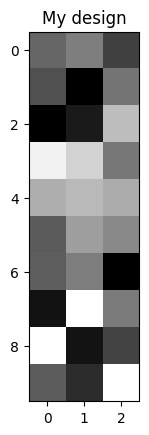

In [5]:
# Do design display for a random set of regressor columns.
random_X = rng.normal(size=(10, 3))
show_x(random_X, 'My design')

## Exploring simple regression

We start with a simple linear regression of one variable against another
: $\vec{y} \approx \beta_1 \vec{x_1} + C$.  $\vec{y}$ is the vector of data we
want to predict using the covariate vector $\vec{x_1}$ times some slope
$\beta_1$ plus an intercept $C$.  Let's imagine that our data $\vec{y} = y_1
... y_N$ are a vector of citation scores for $N$ authors.  Maybe the values in
our covariate vector $\vec{x_{1}} = x_{1_1} .. x_{1_N}$ are the ages of author
$i$.

In [6]:
N = 15
x1 = [49., 50, 45, 53, 69, 73, 35, 40, 36, 30, 49, 36, 73, 61, 74]
y = [ 132.03, 98.64, 146.24, 97.9, 145.12, 191.78, 155.34, 123.08, 140.87,
      122.51, 146.08, 89.3, 134.52, 89.16, 136.08]

In [7]:
%%R -i x1,y -o X
XYfit = lm(y~x1)
X = model.matrix(XYfit)

In [8]:
X

array([[ 1., 49.],
       [ 1., 50.],
       [ 1., 45.],
       [ 1., 53.],
       [ 1., 69.],
       [ 1., 73.],
       [ 1., 35.],
       [ 1., 40.],
       [ 1., 36.],
       [ 1., 30.],
       [ 1., 49.],
       [ 1., 36.],
       [ 1., 73.],
       [ 1., 61.],
       [ 1., 74.]])

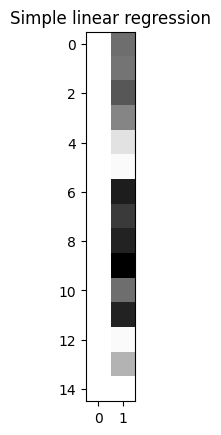

In [9]:
show_x(X, 'Simple linear regression')

We don't have to specify data to get a model matrix:

In [10]:
%R model.matrix(~ x1)

array([[ 1., 49.],
       [ 1., 50.],
       [ 1., 45.],
       [ 1., 53.],
       [ 1., 69.],
       [ 1., 73.],
       [ 1., 35.],
       [ 1., 40.],
       [ 1., 36.],
       [ 1., 30.],
       [ 1., 49.],
       [ 1., 36.],
       [ 1., 73.],
       [ 1., 61.],
       [ 1., 74.]])

OK, so the first thing we see is that R decided we wanted an intercept.  The
intercept became a column of ones in the design matrix, and goes first in the
design matrix.  So, our model above, `y ~ x1` is in fact `y ~ x1 + 1` in
R terms:

In [11]:
%R model.matrix(~x1 + 1)

array([[ 1., 49.],
       [ 1., 50.],
       [ 1., 45.],
       [ 1., 53.],
       [ 1., 69.],
       [ 1., 73.],
       [ 1., 35.],
       [ 1., 40.],
       [ 1., 36.],
       [ 1., 30.],
       [ 1., 49.],
       [ 1., 36.],
       [ 1., 73.],
       [ 1., 61.],
       [ 1., 74.]])

We see also that there's nothing we can do about where the column of ones goes; it goes at the front.  This is a specific application of some general rules that R applies when making the design matrix from a formula, as we'll see later.

If we already have a constant in the model we still get a new one, whether we asked for one or not.

In [12]:
C = np.ones((N,))
%Rpush C
%R model.matrix(~x1 + C)

array([[ 1., 49.,  1.],
       [ 1., 50.,  1.],
       [ 1., 45.,  1.],
       [ 1., 53.,  1.],
       [ 1., 69.,  1.],
       [ 1., 73.,  1.],
       [ 1., 35.,  1.],
       [ 1., 40.,  1.],
       [ 1., 36.,  1.],
       [ 1., 30.,  1.],
       [ 1., 49.,  1.],
       [ 1., 36.,  1.],
       [ 1., 73.,  1.],
       [ 1., 61.,  1.],
       [ 1., 74.,  1.]])

But we can turn off the added constant by hand with the '- 1' shorthand:

In [13]:
%R model.matrix(~x1 - 1)

array([[49.],
       [50.],
       [45.],
       [53.],
       [69.],
       [73.],
       [35.],
       [40.],
       [36.],
       [30.],
       [49.],
       [36.],
       [73.],
       [61.],
       [74.]])

Multiple regression :

$$
\vec{y} \approx \beta_1 \vec{x_1} + \beta_2 \vec{x_2} + C
$$

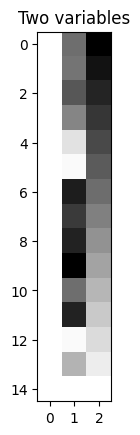

In [14]:
x2 = np.arange(N)
%Rpush x2
X = %R model.matrix(~ x1 + x2)
show_x(X, 'Two variables')

Yes, intercept at the front, `x1`, then `x2`

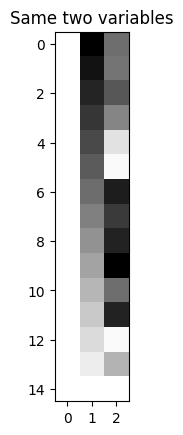

In [15]:
X = %R model.matrix(~ x2 + x1)
show_x(X, 'Same two variables')

You can see from the plot above that the order of columns in the design matrix is determined by order of entry of variables into the formula.

R uses `:` for expressing the *interaction* between variables:

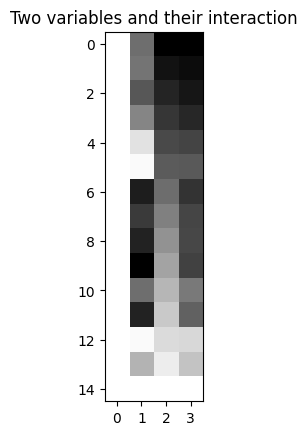

In [16]:
X = %R model.matrix(~x1 + x2 + x1:x2)
show_x(X, "Two variables and their interaction")

In this case it is an interaction between two numerical variables, but later we'll see interaction between factors.  The interaction column for two numerical variables like `x1` and `x2` is the elementwise product of `x1` and `x2`.

In [17]:
np.all(X[:,3] == x1 * x2)

True

The interaction column always comes after the "main effects" `x1` and `x2`, no matter how we ask for them

In [18]:
X2 = %R model.matrix(~ x1:x2 + x1 + x2)
if np.all(X == X2):
    print("Designs are the same")
%R print(coef(lm(y ~ x1:x2 + x1 + x2)))

Designs are the same
(Intercept)          x1          x2       x1:x2 
78.19705800  1.15405802  2.57086251 -0.06924777 


array([ 7.81970580e+01,  1.15405802e+00,  2.57086251e+00, -6.92477655e-02])

All the interactions come after all the main effects, even if there are other main effect not related to the interactions

In [19]:
x3 = rng.normal(size=(N,))
x4 = rng.normal(size=(N,))
%Rpush x3 x4

In [20]:
%R print(coef(lm(y ~ x1 + x2 + x1:x2 + x3 + x4)))

(Intercept)          x1          x2          x3          x4       x1:x2 
66.14220630  1.40034524  4.02595729 14.29322726 18.31877529 -0.07657966 


array([66.1422063 ,  1.40034524,  4.02595729, 14.29322726, 18.31877529,
       -0.07657966])

## Factors in formulae

Quoting again from the Chambers and Hastie chapter, section 2.2.1: "A factor is an object that represents values from some specified set of possible *levels*".  For example, we might have a 'nationality' factor that represents the nationality of subjects in our sample.  Maybe the subjects all come from one of the USA, UK or France.

In [21]:
nationality = ['USA'] * 5 + ['UK'] * 5 + ['France'] * 5

Because this is a string variable, R's formula will assume this is a factor

In [22]:
%Rpush nationality

In [23]:
%R print(model.matrix( ~ nationality))

   (Intercept) nationalityUK nationalityUSA
1            1             0              1
2            1             0              1
3            1             0              1
4            1             0              1
5            1             0              1
6            1             1              0
7            1             1              0
8            1             1              0
9            1             1              0
10           1             1              0
11           1             0              0
12           1             0              0
13           1             0              0
14           1             0              0
15           1             0              0
attr(,"assign")
[1] 0 1 1
attr(,"contrasts")
attr(,"contrasts")$nationality
[1] "contr.treatment"



array([[1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

To be more specific, and avoid the warning, we'll tell R that `nationality` is a factor:

In [24]:
%%R
nationality = factor(nationality)
print(levels(nationality))
print(model.matrix( ~ nationality))

[1] "France" "UK"     "USA"   
   (Intercept) nationalityUK nationalityUSA
1            1             0              1
2            1             0              1
3            1             0              1
4            1             0              1
5            1             0              1
6            1             1              0
7            1             1              0
8            1             1              0
9            1             1              0
10           1             1              0
11           1             0              0
12           1             0              0
13           1             0              0
14           1             0              0
15           1             0              0
attr(,"assign")
[1] 0 1 1
attr(,"contrasts")
attr(,"contrasts")$nationality
[1] "contr.treatment"



First note the levels.  R has sorted the levels alphabetically from the values in the vector.  So, the first level is now "France". Note the design matrix.  The intercept is there by default.  There are then two columns representing the factor.  The first is a column representing the difference between the reference level (the first level, "France") and the second level ("UK").  The second is a column representing the difference between "France" and "USA".  This is one of several possible choices for dummy variable coding of a factor in the design matrix.  This particular coding is called 'treatment' coding.  You'll see that noted as `'contr.treatment'` at the end of the model matrix printed output.  It's called 'treatment' coding because the first level is taken to be the 'no treatment' level and the others are taken to be 'treatment' groups to be compared to the no-treatment control.

It is interesting to think about the interpretetation of the coefficients $\hat\beta$. In this specific example, these coefficients are easily related to the difference of means between "UK" and "France", or "USA" and "France", but not directly to the mean of the observations for a specific country.

To see this, we think of the *fitted values* - that is, the values $\hat{y}_i$.  What is the mean of the fitted values for $\hat{y}_i$ for the "USA" authors?

$$
\frac{1}{5} \sum_{i=1}^5 \hat{y}_i = \hat\beta_1 + \hat\beta_3
$$

In the same way, the mean for the fitted values for the "UK" are:

$$
\frac{1}{5} \sum_{i=6}^{10}\hat{y}_i = \hat\beta_1 + \hat\beta_2 
$$

and for "France":

$$
\frac{1}{5} \sum_{i=11}^{15} \hat{y}_i = \hat\beta_1 
$$

So the mean for the fitted values for the "USA" compared to the baseline is indeed our third coefficient:

$$
\frac{1}{5}\sum_{i=1}^5 \hat{y}_i - \frac{1}{5}\sum_{i=11}^{15} \hat{y}_i = \hat\beta_3
$$

There are various ways of changing how the factor gets coded as columns in the design matrix.  For example:

In [25]:
%R print(model.matrix( ~ C(nationality, helmert)))

   (Intercept) C(nationality, helmert)1 C(nationality, helmert)2
1            1                        0                        2
2            1                        0                        2
3            1                        0                        2
4            1                        0                        2
5            1                        0                        2
6            1                        1                       -1
7            1                        1                       -1
8            1                        1                       -1
9            1                        1                       -1
10           1                        1                       -1
11           1                       -1                       -1
12           1                       -1                       -1
13           1                       -1                       -1
14           1                       -1                       -1
15           1           

array([[ 1.,  0.,  2.],
       [ 1.,  0.,  2.],
       [ 1.,  0.,  2.],
       [ 1.,  0.,  2.],
       [ 1.,  0.,  2.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.],
       [ 1., -1., -1.]])

This coding is of type 'helmert'; the first column encodes the difference between 'UK' and 'France'; the second is the difference between 'USA' and the average of ('UK', 'France').

You can even pass in your own contrast matrices or vectors.  If a vector, as below, then R fills out the rest of the contrast matrix to make coding columns that cover the space of the factor.

In [26]:
%R print(model.matrix( ~ C(nationality, c(2,-1,-1))))

   (Intercept) C(nationality, c(2, -1, -1))1 C(nationality, c(2, -1, -1))2
1            1                            -1                  7.071068e-01
2            1                            -1                  7.071068e-01
3            1                            -1                  7.071068e-01
4            1                            -1                  7.071068e-01
5            1                            -1                  7.071068e-01
6            1                            -1                 -7.071068e-01
7            1                            -1                 -7.071068e-01
8            1                            -1                 -7.071068e-01
9            1                            -1                 -7.071068e-01
10           1                            -1                 -7.071068e-01
11           1                             2                 -5.551115e-17
12           1                             2                 -5.551115e-17
13           1           

array([[ 1.00000000e+00, -1.00000000e+00,  7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00,  7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00,  7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00,  7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00,  7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00, -7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00, -7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00, -7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00, -7.07106781e-01],
       [ 1.00000000e+00, -1.00000000e+00, -7.07106781e-01],
       [ 1.00000000e+00,  2.00000000e+00, -5.55111512e-17],
       [ 1.00000000e+00,  2.00000000e+00, -5.55111512e-17],
       [ 1.00000000e+00,  2.00000000e+00, -5.55111512e-17],
       [ 1.00000000e+00,  2.00000000e+00, -5.55111512e-17],
       [ 1.00000000e+00,  2.00000000e+00, -5.55111512e-17]])

"treatment" and "helmert" and the `c(2, -1, -1)` option are *contrast* codings of the factor.  By "coding" I mean the coding of the factor in terms of dummy variables in the design matrix.  As the name implies, the contrast codings encode the means implied by the factors by contrasting the different levels.  Specifically for the default "treatment" coding, the coding contrasts the second level to the first, and the third level to the first.

## An interlude on vector spaces

I've deliberately used the vague phrase 'encode the means' above, but now I'll get more specific.

The design matrix $X$ is best thought of as the concatenation of the column vectors $x_1 .. x_P$ where $X$ is shape (dimension) $N, P$.  When we estimate our linear model, there will be a corresponding $P$ length vector of coefficients $\beta_1 .. \beta_P$ - call this vector $\vec{b}$. We will fit our data $\vec{y}$ by choosing coefficients $\vec{b}$ such that $\vec{y} \approx X \vec{b}$ in some sense of $\approx$, such as least squares.

For convenience, let's drop the vector notation of $\vec{b}$, and write $\vec{b}$ as $B$.

The columns of $X$ define a *vector space*.  We can call this the *column space* of $X$. The column space of $X$ is the set of all vectors that can be formed by a some linear combination of the columns of $X$. For a given $B$, $X B$ is one particular vector in the column space of $X$.  The column space of a matrix $X$ obviously defines the range of vectors $X B$, and therefore constrains the ability of the design $X$ to fit the data $Y$.

The column space of a matrix $W$ contains (spans) the column space of another matrix $X$ if, for all columns $x_1 .. x_i .. x_P$ there is some vector $B_i$ such that $x_i = W B_i$.  Let's say $W$ has $P_W$ columns. If we stack the column vectors $B_i$ into a $P_W, P$ matrix $C$ then we can rephrase the rule as: there is some matrix $C$ such that $X = W C$.

## Vector spaces, design matrices and factors

Now let us return to the factor `nationality`.  What do we mean by a "factor"?  We mean that the observations $y_1 .. y_N$ each belong to one and only one of three groups, where the groups are "USA", "UK", and "France".  In terms of our statistical model, by including the factor `nationality`, we mean this:

$y_i \approx \alpha_{USA} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{USA}$

$y_i \approx \alpha_{UK} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{UK}$

$y_i \approx \alpha_{France} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{France}$

I can rephrase this model in terms of matrices by using "indicator coding".  There will be three columns in my matrix.  The first will be the indicator column for "USA", that contains a $1$ for rows corresponding to observations of type "USA" and a $0$ otherwise.  The second will contain a $1$ for "UK" observations, and the third a $1$ for "France" observations.

In [27]:
nationality = np.array(nationality)
indicate_usa = nationality == 'USA'
indicate_uk = nationality == 'UK'
indicate_france = nationality == 'France'
X = np.column_stack((indicate_usa, indicate_uk, indicate_france)).astype(int)
X

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

We can now rephrase our factor model by stacking our coefficients $\alpha_{USA}, \alpha_{UK}, \alpha_{France}$ into a column vector $A$, and rephrasing our model in matrix form as $\vec{y} = X A$. 

In this case, the parameters $\hat\beta$ are easily interpreted as the means of each group, since we have :

$$
\frac{1}{5}\sum_{i=1}^5 \hat{y}_i =  \hat\beta_1
$$
$$
\frac{1}{5}\sum_{i=6}^{10} \hat{y}_i = \hat\beta_2 
$$
$$
\frac{1}{5}\sum_{i=11}^{15} \hat{y}_i = \hat\beta_3 
$$


What if we want to add an intercept to our design matrix $X$?  Let's call the design matrix with the intercept $W$:

In [28]:
W = np.column_stack((np.ones(N,), X))
W

array([[1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.]])

Our design has four columns, but one of them does not contribute to the column space of $W$, because $w_1 = w_2 + w_3 + w_4$.  That is the same as saying that any vector $S * w_1$ (where $S$ is a scalar) can be exactly given by $S * w2 + S * w_3 + S * w_4$.  Put another way, $X$ (with three column vectors) contains the column space of $W$ (with 4 column vectors).

What should we do about this?  There are two options.  One is - do nothing.  Our design matrix $W$ has one column more than the minimum needed to span the column space, and if we find some parameters $B$ to fit the data $Y$ to the design $W$, then we will have to take some care in interpreting the parameters, because there will be a necessary relationship between $\beta_1$ and $\beta_2 + \beta_3 + \beta_4$.

Another option is choose some new and reduced set of vectors to represent the factor, that we can append to the constant column, and that can nevertheless represent the column space of $X$ (the indicator columns).   That is what R refers to as "contrast coding" for factors.  Let's return to the default 'treatment' contrast coding:

In [29]:
Z = %R model.matrix( ~ nationality)
Z

array([[1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Does `Z` contain the column space of the indicator columns $X$?  Yes, because there is a $P, P$ matrix $C$ such that $X = Z C$:

In [30]:
C = np.array([[0, 0, 1], [0, 1, 0], [1, -1, -1]]).T
Z @ C

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

Does the treatment contrast coding have exactly the same column space as the indicator columns?  That is, can all vectors that are a combination of the columns of `Z` also be created from combinations of columns of `X`?  Yes, because our matrix $C$ above is invertible. If $C^{-1}$ is the inverse of $C$, then $Z = X C^{-1}$: 

In [31]:
np.all(X @ np.linalg.inv(C) == Z)

True

Therefore all vectors in the space of `Z` are also in the column space of `X`.

As a side-note, I can get the matrix that maps from the 3 indicator columns to the 2 contrast columns like this:

In [32]:
X_indicator = %R model.matrix(~ nationality-1)
X_contrast = %R model.matrix(~ nationality)
# Three levels for nationality
C_map = %R contr.treatment(3)
np.all(X_indicator @ C_map == X_contrast[:, 1:])

True

In [33]:
C_map

array([[0., 0.],
       [1., 0.],
       [0., 1.]])

It's easy to go from there to the full `C` matrix mapping from the indicator design to the intercept + contrast design:

In [34]:
C_map_with_inter = np.column_stack(([1, 1, 1], C_map))
np.all(X_indicator @ C_map_with_inter == X_contrast)

True

How about the "helmert" coding? Does that contain the column space of the indicator coding?

In [35]:
Z = %R model.matrix( ~ C(nationality, helmert))
C = np.array([[1./3, -0.5, -1./6], [1./3, 0.5, -1./6], [1./3, 0, 1./3]]).T
np.set_printoptions(suppress=True) # suppress very small floating point values
Z @ C  # same as X_indicator

array([[ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [-0.,  1.,  0.],
       [-0.,  1.,  0.],
       [-0.,  1.,  0.],
       [-0.,  1.,  0.],
       [-0.,  1.,  0.],
       [ 1., -0.,  0.],
       [ 1., -0.,  0.],
       [ 1., -0.,  0.],
       [ 1., -0.,  0.],
       [ 1., -0.,  0.]])

In fact, if we tell R to leave out the constant column, we will get indicator coding for the factor, with the columns permuted to reflect the fact that R thinks the levels should be ordered "France", "UK", "USA":

In [36]:
%R model.matrix( ~ nationality-1)

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

We now start to see the rules that R is using in constructing the design matrix.  It seems that R is looking at each effect to be added, and for each effect to be added, it is removing anything that can be modeled by columns already in the design matrix.  Later on, we'll make this rule more explicit.

## Factors, interactions and column spaces

Let's define a new factor `awesome` which has levels of "No" (is not awesome) or "Yes" (is too awesome).

In [37]:
awesome = np.array(["Yes", "No"] * 7 + ["Yes"])
awesome

array(['Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No',
       'Yes', 'No', 'Yes', 'No', 'Yes'], dtype='<U3')

To model both these factors independently:

In [38]:
%%R -i awesome
awesome = factor(awesome)
print(model.matrix(~ nationality + awesome))

   (Intercept) nationalityUK nationalityUSA awesomeYes
1            1             0              1          1
2            1             0              1          0
3            1             0              1          1
4            1             0              1          0
5            1             0              1          1
6            1             1              0          0
7            1             1              0          1
8            1             1              0          0
9            1             1              0          1
10           1             1              0          0
11           1             0              0          1
12           1             0              0          0
13           1             0              0          1
14           1             0              0          0
15           1             0              0          1
attr(,"assign")
[1] 0 1 1 2
attr(,"contrasts")
attr(,"contrasts")$nationality
[1] "contr.treatment"

attr(,"contrasts")$

Notice that both `nationality` and `awesome` have "treatment" contrast coding, and that for `awesome` this gives just one column corresponding to the difference between "no treatment" == first level after alphabetical sort == "No", and "treatment" == second level == "Yes".

This allows us to model the effect of `nationality`, and the effect of `awesome`, but what if the effect of `awesome` is different depending on what nationality you are?  Maybe if you are from the "UK", you get cited all the time, even though you are not awesome.  If the effect of `awesome` differs across the levels of `nationality`, then there is said to be an "interaction" between `awesome` and `nationality`.

In order to be able to model any such interaction, we can do the classic analysis of variance trick of breaking up the data into cells defined by every combination of `nationality` and `awesome`:

$y_i \approx \alpha_{USA,Yes} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{USA} \text{ and } \mathtt{awesome}_i \text{ is } \mathtt{Yes}$

$y_i \approx \alpha_{USA,No} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{USA} \text{ and } \mathtt{awesome}_i \text{ is } \mathtt{No}$

$y_i \approx \alpha_{UK,Yes} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{UK} \text{ and } \mathtt{awesome}_i \text{ is } \mathtt{Yes}$

$y_i \approx \alpha_{UK,No} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{UK} \text{ and } \mathtt{awesome}_i \text{ is } \mathtt{No}$

$y_i \approx \alpha_{France,Yes} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{France} \text{ and } \mathtt{awesome}_i \text{ is } \mathtt{Yes}$

$y_i \approx \alpha_{France,No} \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{France} \text{ and } \mathtt{awesome}_i \text{ is } \mathtt{No}$

The indicator coding for this is:

In [39]:
indicator_columns = []
for country in 'USA', 'UK', 'France':
    for quality in 'Yes', 'No':
        indicator_columns.append((nationality == country) & (awesome == quality))
X = np.column_stack(indicator_columns).astype(int)
X

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]])

This can be a little easier to grasp in an image of the design matrix.  Here black corresponds to 0 and white to 1:

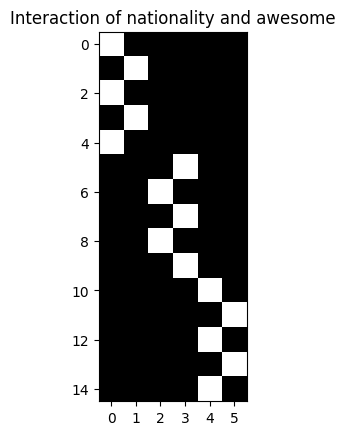

In [40]:
show_x(X, 'Interaction of nationality and awesome')

These columns are also the element-wise products of the indicator columns for each pair of (`nationality`, `awesome`):

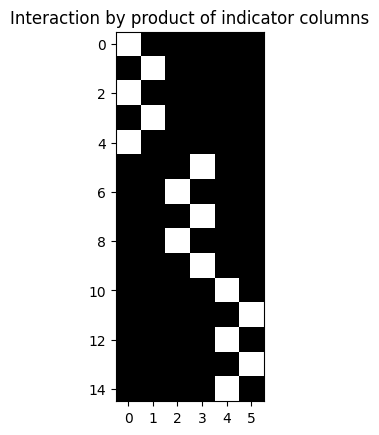

In [41]:
nat_cols = []
for country in 'USA', 'UK', 'France':
    nat_cols.append(nationality == country)
awe_cols = []
for quality in 'Yes', 'No':
    awe_cols.append(awesome == quality)
all_cols = []
for nat_col in nat_cols:
    for awe_col in awe_cols:
        all_cols.append(nat_col * awe_col)
X_again = np.column_stack(all_cols).astype(int)
show_x(X_again, 'Interaction by product of indicator columns')

R formulae represent an interaction with the colon `:`.  We can make R give us this same coding, if we ask for the interaction, and to have no intercept. The columns will be permuted because R orders the factor levels alphabetically.

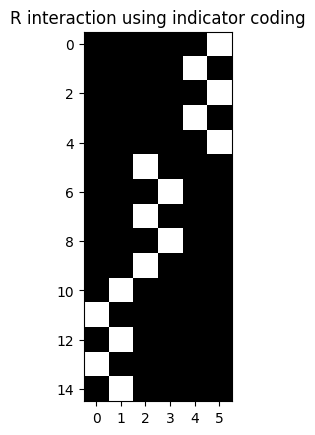

In [42]:
X_r = %R model.matrix(~ awesome:nationality-1)
show_x(X_r, 'R interaction using indicator coding')

Back to column spaces.  The first two columns of X add up to the indicator column for the first country. So, for R's design, the first two columns add up to the indicator coding for 'France'.

In [43]:
X_nations = %R model.matrix(~ nationality-1)
X_nations[:, 0] == X_r[:, 0] + X_r[:, 1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

Similarly, the first, third and fifth columns add up to the indicator coding for "No":

In [44]:
X_awesome = %R model.matrix(~ awesome-1)
X_awesome[:, 0] == np.sum(X_r[:, (0, 2, 4)], axis=1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

So, the indicator coding for the interaction, contains the column space of the indicator coding for the individual factors.  Put another way, anything that can be fit with the model `nationality-1` and anything that can be fit by `awesome-1` can also be fit by the model `nationality:awesome-1`.  As we saw before, the column space of `nationality` is the same as the column space of `nationality-1`, as is also true of the pairs (`awesome`, `awesome-1`), (`nationality:awesome`, `nationality:awesome-1`), (`nationality + awesome`, `nationality + awsome-1`).  So, the model `nationality:awesome` contains the column space of `nationality + awesome`.

## The intercept, main effects and interaction effects

Consider a simple model of our data `y`, in which we have only an intercept (constant) term: $y_i = \mu$. In a model fit with ordinary least squares, $\mu$ will be the mean of the observations `y`.  Compare this to the model we have seen before in which each country has its own characteristic value:

$\begin{array}{cl}
y_i \approx \alpha_{USA} & \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{USA} \cr
y_i \approx \alpha_{UK} & \text{ if } \mathtt{nationality}_i \text{ is } \mathtt{UK} \cr
y_i \approx \alpha_{France} &\text{ if } \mathtt{nationality}_i \text{ is } \mathtt{France}
\end{array}$

Again, for ordinary least squares, the values $\alpha_{USA}, \alpha_{UK}, \alpha_{France}$ will be the respective means of the values `Y` for authors from countries "USA", "UK" and "France" respectively.

The *main effect* of `nationality` is the difference between the intercept-only model $y_i = \mu$ and the second model with intercepts specific to each nationality.

More generally, the main effect of a factor is the difference between a model that has a single intercept for all observations, compared to a model that has separate intercepts for each groups defined by the factor levels.

Therefore, a main effect is a difference in a model caused by modeling the *differences* between the intercepts for the groups defined by the factor levels.

We can see this distinction in the way that R constructs the design for a single factor.  We've seen this before of course:

In [45]:
%%R
fit_with_intercept = lm(y ~ nationality)
print(model.matrix(fit_with_intercept))

   (Intercept) nationalityUK nationalityUSA
1            1             0              1
2            1             0              1
3            1             0              1
4            1             0              1
5            1             0              1
6            1             1              0
7            1             1              0
8            1             1              0
9            1             1              0
10           1             1              0
11           1             0              0
12           1             0              0
13           1             0              0
14           1             0              0
15           1             0              0
attr(,"assign")
[1] 0 1 1
attr(,"contrasts")
attr(,"contrasts")$nationality
[1] "contr.treatment"



So, the model starts with the intercept, and continues with two columns that complete the column spaces spanned by the model with the indidual intercepts.   That is, the design can be considered as two designs one after the other, the intercept-only design (a column of ones) and the remaining column space of the indicator columns for the three intercept model.  Let's now look at the summary of the fit:

In [46]:
%R print(summary(fit_with_intercept))


Call:
lm(formula = y ~ nationality)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.868 -24.776   8.044  19.093  45.064 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     119.028     12.008   9.912 3.94e-07 ***
nationalityUK    27.688     16.982   1.630    0.129    
nationalityUSA    4.958     16.982   0.292    0.775    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.85 on 12 degrees of freedom
Multiple R-squared:  0.2012,	Adjusted R-squared:  0.06812 
F-statistic: 1.512 on 2 and 12 DF,  p-value: 0.2597



o{'call': 
Call:
lm(formula = y ~ nationality)

Coefficients:
   (Intercept)   nationalityUK  nationalityUSA  
       119.028          27.688           4.958  

, 'terms': y ~ nationality
attr(,"variables")
list(y, nationality)
attr(,"factors")
            nationality
y                     0
nationality           1
attr(,"term.labels")
[1] "nationality"
attr(,"order")
[1] 1
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,".Environment")
<environment: R_GlobalEnv>
attr(,"predvars")
list(y, nationality)
attr(,"dataClasses")
          y nationality 
  "numeric"    "factor" 
, 'residuals': [  8.044 -25.346  22.254 -26.086  21.134  45.064   8.624 -23.636  -5.846
 -24.206  27.052 -29.728  15.492 -29.868  17.052], 'coefficients': [[119.028       12.00821283   9.91221606   0.00000039]
 [ 27.688       16.98217744   1.63041519   0.12896317]
 [  4.958       16.98217744   0.29195314   0.77530832]], 'aliased':    (Intercept)  nationalityUK nationalityUSA 
         FALSE          FALSE       

We have coefficients for `nationalityUK` and `nationalityUSA` with associated t statistics and p values.   These are meaningful as tests for differences between the group means for nationality, because the overall intercept has been modeled separately. The coefficients and the tests on the coefficients relate to the main effect of nationality. However, if we remove the intercept from the model:

In [47]:
%%R
fit_no_intercept = lm(y ~ nationality -1)
print(summary(fit_no_intercept))


Call:
lm(formula = y ~ nationality - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-29.868 -24.776   8.044  19.093  45.064 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
nationalityFrance   119.03      12.01   9.912 3.94e-07 ***
nationalityUK       146.72      12.01  12.218 3.96e-08 ***
nationalityUSA      123.99      12.01  10.325 2.53e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.85 on 12 degrees of freedom
Multiple R-squared:  0.9672,	Adjusted R-squared:  0.959 
F-statistic:   118 on 3 and 12 DF,  p-value: 3.583e-09



Now group means for each nationality must model the overall mean across all nationalities, and the values of the coefficients therefore no longer reflect the difference between the intercept-only model and the the model with separate intercepts for each group that we fit here.

By adding the intercept to the model by default, R makes the default coefficients relate to the expected test of interest, which is for the main effect of the factor.  The main effect of the factor is the comparison between the intercept only model and the model with the factor level intercepts.

We remember that the design matrix for the intercept (`model.matrix(fit_with_intercept)`) and the design matrix without the intercept (`model.matrix(fit_no_intercept)`) have the same *column space*.  In fact, strictly speaking, they are identical model with different parametrization, but they really model the same things.  It is the column space that determines what the design is able to fit in the data, so we see that the two design matrix have the same `Residual standard error` in the summaries above, and:

In [48]:
%R sum(abs(fit_no_intercept$residuals - fit_with_intercept$residuals))

array([0.])

Now we know why R might prefer to insert the intercept for single factor models, we may be some way to explaining the following mystery:

The most typical two factor and interaction formula in R looks (in effect) like this:

`y ~ nationality + awesome + nationality:awesome`

(I say, "in effect", because that formula is usually written with the shortcut form of `y ~ nationality * awesome`; more on the shortcuts later).

The mystery is this: we know that:

`y ~ nationality:awesome`

covers the same column space.  Why prefer the more verbose form (or - with the shortcut - the slightly more obscure form)?

The answer is the same as for the inclusion of intercept in the single-factor design; it makes it easier to interpret the parts of the design matrix in an hierarchical way.  For the intercept and the single factor, including the intercept made the columns of the design refer to the main effect (comparison between the intercept model and factor level intercept model).  Including the main effects separately from the interactions in the formula means that the first colums in the design refer to the main effect, and the later columns refer to the *added* effect of the interaction.

Let's have a look at the standard R form of this model with main effects and interactions:

In [49]:
%R fit_main_inters = lm(y ~ nationality + awesome + nationality:awesome)
X_main_inters = %R model.matrix(fit_main_inters)
print(X_main_inters)

[[1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0.]]


You'll recognize the first three columns as being the same as those for `~ nationality`.  The fourth column is the contrast coding for `awesome`, and is what we expected.  The last two columns encode the (remainder of) the interaction.  What are these last two columns?  Let's get the names:

In [50]:
names = %R colnames(model.matrix(fit_main_inters))
for i, name in enumerate(names):
    print(i, name)

0 (Intercept)
1 nationalityUK
2 nationalityUSA
3 awesomeYes
4 nationalityUK:awesomeYes
5 nationalityUSA:awesomeYes


And in fact:

In [51]:
print(np.all(X_main_inters[:, 4] == X_main_inters[:, 1] * X_main_inters[:, 3]))
print(np.all(X_main_inters[:, 5] == X_main_inters[:, 2] * X_main_inters[:, 3]))

True
True


The fit:

In [52]:
%R print(summary(fit_main_inters))


Call:
lm(formula = y ~ nationality + awesome + nationality:awesome)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.280  -5.804  -0.070   4.550  45.990 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 89.230     13.907   6.416 0.000123 ***
nationalityUK               56.560     17.954   3.150 0.011732 *  
nationalityUSA               9.040     19.667   0.460 0.656674    
awesomeYes                  49.663     17.954   2.766 0.021890 *  
nationalityUK:awesomeYes   -47.348     25.391  -1.865 0.095084 .  
nationalityUSA:awesomeYes   -6.803     25.391  -0.268 0.794780    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.67 on 9 degrees of freedom
Multiple R-squared:  0.6786,	Adjusted R-squared:    0.5 
F-statistic:   3.8 on 5 and 9 DF,  p-value: 0.03967



o{'call': 
Call:
lm(formula = y ~ nationality + awesome + nationality:awesome)

Coefficients:
              (Intercept)              nationalityUK  
                   89.230                     56.560  
           nationalityUSA                 awesomeYes  
                    9.040                     49.663  
 nationalityUK:awesomeYes  nationalityUSA:awesomeYes  
                  -47.348                     -6.803  

, 'terms': y ~ nationality + awesome + nationality:awesome
attr(,"variables")
list(y, nationality, awesome)
attr(,"factors")
            nationality awesome nationality:awesome
y                     0       0                   0
nationality           1       0                   1
awesome               0       1                   1
attr(,"term.labels")
[1] "nationality"         "awesome"             "nationality:awesome"
attr(,"order")
[1] 1 1 2
attr(,"intercept")
[1] 1
attr(,"response")
[1] 1
attr(,".Environment")
<environment: R_GlobalEnv>
attr(,"predvars")
list(y, na

We see the same principle as before; the later columns can be interpreted as tests of the extra effects over and above the earlier columns.  Specifically, the design matrix here has 0-order effects first (the intercept), followed by first-order (nationality, awesome - over and above the zero order effect), followed by the second order effects (nationality interaction with awesome over and above the first order effects).

Compare the interaction-only model, that has the same column space.  For clarity, let's omit the intercept to get indicator coding for the factor level pairs:

In [53]:
%R fit_inters = lm(y ~ nationality:awesome-1)
X_inters = %R model.matrix(fit_inters)
print(X_inters)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


Do `X_inter` and `X_main_inters` have the same column space as I have claimed?  We see first that they have the same `Residual standard error`:

In [54]:
%R print(summary(fit_inters))


Call:
lm(formula = y ~ nationality:awesome - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.280  -5.804  -0.070   4.550  45.990 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
nationalityFrance:awesomeNo     89.23      13.91   6.416 0.000123 ***
nationalityUK:awesomeNo        145.79      11.36  12.839 4.32e-07 ***
nationalityUSA:awesomeNo        98.27      13.91   7.066 5.88e-05 ***
nationalityFrance:awesomeYes   138.89      11.36  12.232 6.54e-07 ***
nationalityUK:awesomeYes       148.10      13.91  10.650 2.11e-06 ***
nationalityUSA:awesomeYes      141.13      11.36  12.429 5.71e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.67 on 9 degrees of freedom
Multiple R-squared:  0.9868,	Adjusted R-squared:  0.978 
F-statistic: 112.2 on 6 and 9 DF,  p-value: 6.075e-08



o{'call': 
Call:
lm(formula = y ~ nationality:awesome - 1)

Coefficients:
 nationalityFrance:awesomeNo       nationalityUK:awesomeNo  
                       89.23                        145.79  
    nationalityUSA:awesomeNo  nationalityFrance:awesomeYes  
                       98.27                        138.89  
    nationalityUK:awesomeYes     nationalityUSA:awesomeYes  
                      148.10                        141.13  

, 'terms': y ~ nationality:awesome - 1
attr(,"variables")
list(y, nationality, awesome)
attr(,"factors")
            nationality:awesome
y                             0
nationality                   2
awesome                       2
attr(,"term.labels")
[1] "nationality:awesome"
attr(,"order")
[1] 2
attr(,"intercept")
[1] 0
attr(,"response")
[1] 1
attr(,".Environment")
<environment: R_GlobalEnv>
attr(,"predvars")
list(y, nationality, awesome)
attr(,"dataClasses")
          y nationality     awesome 
  "numeric"    "factor"    "factor" 
, 'residuals': [ 

Is there a matrix `C` such that `X_main_inters = X_inters @ C`?  (`@` is matrix multiply in Numpy). Yes:

In [55]:
C = np.linalg.pinv(X_inters) @ X_main_inters
np.allclose(X_inters @ C, X_main_inters)

True

From the fit above, we see that the individual coefficients in the `fit_inters` fit carry the effect of the (otherwise not-modeled) global intercept, and in fact they also carry the main effects.  That makes sense because the intercept and main effect and interaction are all modeled with the same set of columns.

## Column space and contrast matrices

If two design matrices have the same column space, then any comparison possible for the first model is also possible for the second, with suitable *contrast matrices*.  Consider the designs above for the `nationality` factor, with and without the intercept.

Remember that the design with the intercept gave us coefficients reflecting the *treatment contrast* for the factor main effect. But, the design without the intercept has the same column space.  What if have coefficients for the no-intercept design matrix, but I want the coefficients I would have got for the with-intercept design?

Call our design matrix with intercept $X_W$, and the design matrix without the intercept $X_N$.   The fitted values $\hat{\vec{y}}$ for any design $X$ are given by:

$\hat{\vec{y}} = X B$

where $B$ is the column vector of coefficients from the fit (for example: `coef(fit_no_intercept))`).   So for the no-intercept design:

$\hat{\vec{y}} = X_N B_N$

I postulate there is a vector of parameters $B_W$ for the with-intercept design that gives me exactly the same fitted values, so:

$
\hat{\vec{y}} = X_W B_W \implies
X_W B_W = X_N B_N
$

We want to know what $B_W$ are given $B_N$.

Because the intercept design $X_W$ spans the column space of $X_N$, we know that there is some matrix $C$ such that $X_N = X_W C$.  Therefore:

$X_W B_W = X_W C B_N$

This will be true if:

$B_W = C B_N$

So, we need the matrix $C$ mapping the columns of $X_W$ to the columns of $X_N$.  $C$ is our contrast matrix.


R will give us the matrix to construct the contrast columns from the indicator columns; this maps the columns of $X_W$ to the columns of $X_N$.

In [56]:
# 3 factor levels for nationality
C_ind2treat = %R contr.treatment(3)
C_N2W = np.column_stack(([1, 1, 1], C_ind2treat)) # Add intercept generating column
X_N = %R model.matrix(fit_no_intercept)
X_W = %R model.matrix(fit_with_intercept)
print(np.all(X_N @ C_N2W == X_W)) # Confirm we have C' to map X_N to X_W

True


We have the mapping from `X_N` to `X_W`, but we want $C$ to map `X_W` to `X_N`.  Call this `C_W2N`. Luckily `C_N2W` is invertible, and we have our `C_W2N` with one bound:

In [57]:
C_W2N = np.linalg.inv(C_N2W) # The C we want
print(np.all(X_W @ C_W2N == X_N)) # confirm it's the C we want

True


Now we can get the $B_N$ cooefficients from the $B_W$ coefficients without reestimating the design:

In [58]:
# No intercept coefficients
B_N = %R coef(fit_no_intercept)
# Make into a column vector for dot product
B_N = B_N.reshape(-1, 1)
# Estimate coefficients for with-intercept model
B_I_est = C_W2N @ B_N
B_I = %R coef(fit_with_intercept)
print("Coefficients from intercept model", B_I)
print("Coefficients recreated from non-intercept model", B_I_est.T)

Coefficients from intercept model [119.028  27.688   4.958]
Coefficients recreated from non-intercept model [[119.028  27.688   4.958]]


## Formulae and ANOVA tables

We've seen that R uses the formula to do some partitioning of the design matrix.  We've seen for example that `~ nationality + awesome + nationality:awesome` has the the same column space as `~ nationality:awesome` but that the coefficients are different, because, in the first case, R partitions the design into (first) main effects, then interactions.

R uses the order of elements in the formula for even more explicit partioning when doing ANOVA tables.

In [59]:
%%R
fit_sequential = lm(y ~ nationality + awesome + nationality:awesome)
print(anova(fit_sequential))

Analysis of Variance Table

Response: y
                    Df Sum Sq Mean Sq F value Pr(>F)  
nationality          2 2179.8  1089.9  2.8176 0.1121  
awesome              1 3597.7  3597.7  9.3010 0.0138 *
nationality:awesome  2 1572.8   786.4  2.0331 0.1868  
Residuals            9 3481.3   386.8                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The ANOVA table reports sequential tests as each element enters the formula.  The first line in the table compares the model `~ 1` (intercept only) to `~ 1 + nationality`.   The second line compares `~ 1 + nationality` to `~1 + nationality + awesome`.  The third line compares `~1 + nationality + awesome` to `~ 1 + nationality + awesome + nationality:awesome`.   By "compares the model" I mean, do an F test where the numerator is (extra sum of squares error explained by the second (larger) model compared to the first (smaller) model, divided by the extra degrees of freedom used by second compared to the first model).  The denominator is the (sum of squared residuals from `~ 1 + nationality + awesome + nationality:awesome` model divided by the degrees of freedom used by this model).  For example, to get the first F value in the table we take the sum of squares explained by the `~ 1 + nationality` model (below) (2176.8), divide by the degrees of freedom (2), then divide by (the residual sum of squares for the full model (above) (3481.3), divided by the degrees of freedom for the full model (9)):

In [60]:
%R print(anova(lm(y ~ nationality)))
(2179.8 / 2) / (3481.3 / 9)

Analysis of Variance Table

Response: y
            Df Sum Sq Mean Sq F value Pr(>F)
nationality  2 2179.8 1089.88  1.5117 0.2597
Residuals   12 8651.8  720.99               


2.8176543245339385

This sequential form of testing is sometimes called *type I sum of squares*.  

The order is strictly sequential, so it makes a difference which order you enter the factors in the formula.  For example, compare:

In [61]:
%%R
print(anova(lm(y ~ nationality + awesome)))
print(anova(lm(y ~ awesome + nationality)))


Analysis of Variance Table

Response: y
            Df Sum Sq Mean Sq F value  Pr(>F)  
nationality  2 2179.8  1089.9  2.3721 0.13916  
awesome      1 3597.7  3597.7  7.8303 0.01733 *
Residuals   11 5054.1   459.5                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table

Response: y
            Df Sum Sq Mean Sq F value  Pr(>F)  
awesome      1 2520.3 2520.27  5.4852 0.03903 *
nationality  2 3257.2 1628.61  3.5446 0.06484 .
Residuals   11 5054.1  459.46                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


For more detail, see the R FAQ section "Why does the output from anova() depend on the order of factors in the model?"

Needless to say, entering the interaction-only formula changes the table too:

In [62]:
%R print(anova(lm(y ~ nationality:awesome)))

Analysis of Variance Table

Response: y
                    Df Sum Sq Mean Sq F value  Pr(>F)  
nationality:awesome  5 7350.3 1470.06  3.8005 0.03967 *
Residuals            9 3481.3  386.81                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
nationality:awesome,5,7350.309283,1470.061857,3.800478,0.039672
Residuals,9,3481.287917,386.809769,NaN,NaN


## From R formula to design matrix

These is an attempt to set out the rules, as I understand them, for going from an R formula to a a design matrix.  There are three stages:

1. Expanding shortcuts to create terms
2. Reordering terms
3. Coding of factors in terms

In what follows, I will use the name *element* for a factor (such as `nationality`) or a numerical numerical variable (such as `x1`).  A *term* is either the intercept (`1`) or an element (such as `nationality`, or an interaction between two or more elements (e.g. `x1:nationality:awesome`). The order of a term is the number of contained elements.  `1` is a term with zero elements. Examples of terms with their orders are:

* `1` - order 0
* `nationality` - order 1
* `nationality:x1` - order 2
* `x1:x2:awesome` - order 3

### Expanding model shortcuts

There are 4 syntactic shortcuts.  Here is a list, with their translations to the basic operators of "+" and ":".  In the *expansion* phase, R translates the shortcuts to their meaning given here:

* `A * B`  $\implies$ `A + B + A:B`
   * `A * B * C`  $\implies$ `A + B + C + A:B + A:C + B:C + A:B:C` 
* `A %in% B` $\implies$ `A:B`
* `A / B` $\implies$ `A + A:B`
* `A + B - A` $\implies$ `B`
   * `A + B + A:B - B` $\implies$ `A + A:B`
* `(A + B + C)^2` $\implies$ `A + B + C + A:B + A:C`
   * `(A + B + C)^3` $\implies$ `A + B + C + A:B + A:C + B:C + A:B:C`

Let's see them in action by looking at the "terms" created from formulae in R:

In [63]:
%%R
print(attributes(terms(~A * B))$term)
print(attributes(terms(~A * B * C))$term)
print(attributes(terms(~A %in% B))$term)
print(attributes(terms(~A / B))$term)
print(attributes(terms(~A + B - A))$term)
print(attributes(terms(~A + B + A:B - B))$term)
print(attributes(terms(~(A + B + C)^2))$term)
print(attributes(terms(~(A + B + C)^3))$term)

[1] "A"   "B"   "A:B"
[1] "A"     "B"     "C"     "A:B"   "A:C"   "B:C"   "A:B:C"
[1] "A:B"
[1] "A"   "A:B"
[1] "B"
[1] "A"   "A:B"
[1] "A"   "B"   "C"   "A:B" "A:C" "B:C"
[1] "A"     "B"     "C"     "A:B"   "A:C"   "B:C"   "A:B:C"


### Reordering terms

Terms are ordered so that 0 order terms go first, then first order terms, and so on.  The intercept is the only zero order term. Let's see the ordering in action:

In [64]:
%%R
print(attributes(terms(~A:B +1 + B))$term) # actually the intercept does not appear in the terms
print(attributes(terms(~D + A:B:C + A + B + E))$term)

[1] "B"   "A:B"
[1] "D"     "A"     "B"     "E"     "A:B:C"


### Column space of interactions

This is to be specific about the meaning of interactions, in terms of column space.  Any design matrix that models an interaction must contain this column space.

#### Numeric:numeric interactions

The column space of a numeric:numeric interaction is just the elementwise
product of the two numeric variables.  That is, the interaction between two
length $N$ vectors $x, z$ is given by the vector $x_1 z_1, x_2 z_2,... x_P,
z_P$.  For example:

In [65]:
%R print(model.matrix(~ x1 + x2 + x1:x2 - 1))
x1 * x2

   x1 x2 x1:x2
1  49  0     0
2  50  1    50
3  45  2    90
4  53  3   159
5  69  4   276
6  73  5   365
7  35  6   210
8  40  7   280
9  36  8   288
10 30  9   270
11 49 10   490
12 36 11   396
13 73 12   876
14 61 13   793
15 74 14  1036
attr(,"assign")
[1] 1 2 3


array([   0.,   50.,   90.,  159.,  276.,  365.,  210.,  280.,  288.,
        270.,  490.,  396.,  876.,  793., 1036.])

#### Factor:factor interactions

The column space of a factor:factor interaction is given by a set of indicator columns in which there is one indicator column for each unique combination of levels in the two factors. So if the first factor has $P$ levels, and the second factor has $Q$ levels, there will be $P * Q$ columns in the interaction. Put otherwise, the column space of the interaction for two factors $f1, f2$ is given by taking the matrix giving indicator coding for $f1$ (call this $M_1$) and the matrix giving indicator coding for $f2$ (call this $M_2$) and creating a new matrix $M_{1,2}$ that has the products of all columns of $M_1$ with all columns of $M_2$:

In [66]:
X_nat = %R model.matrix(~ nationality - 1) # indicator coding
X_awe = %R model.matrix(~ awesome - 1) # indicator coding
X_both = %R model.matrix(~ nationality:awesome - 1)
print(X_nat)
print(X_awe)
print(X_both)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


#### Factor:numeric interactions

The column space of a factor:numeric interaction is given by taking the matrix giving indicator coding of the factor $f$ (call this $M$) and multiplying each column in $M$ by the numeric variable.  This is a varying slope model, where the slope of the relationship of the response variable $\vec{y}$ and the numeric variable $x$ differs according to the levels of the factor $f$.  For example:

In [67]:
%R model.matrix(~ x1:nationality - 1)

array([[ 0.,  0., 49.],
       [ 0.,  0., 50.],
       [ 0.,  0., 45.],
       [ 0.,  0., 53.],
       [ 0.,  0., 69.],
       [ 0., 73.,  0.],
       [ 0., 35.,  0.],
       [ 0., 40.,  0.],
       [ 0., 36.,  0.],
       [ 0., 30.,  0.],
       [49.,  0.,  0.],
       [36.,  0.,  0.],
       [73.,  0.,  0.],
       [61.,  0.,  0.],
       [74.,  0.,  0.]])

### Coding of factors

Once the terms have been ordered, R has to make a design matrix.  The one decision left is how to code the factors - should they use 'indicator' coding or 'contrast' coding.  The rule is the following:

> Suppose we have an expanded formula with $p$ factors [*elements* in my terminology]: $F_1,F_2,...,F_p$.  and $m$ terms: $T_1 + T_2+...+T_m$ ...

> "Suppose $F_J$ is any factor included in term $T_i$.  Let $T_{i(j)}$ denote the *margin* of $T_i$ for factor $F_j$ - that is, the term obtained by dropping $F_j$ from $T_i$.  We say that $T_{i(j)}$ has appeared in the formula if there is some term $T_{i'}$ for $i' < i$ such that $T_{i'}$ contains all the factors appearing in $T_{i(j)}$.  The usual case is that $T_{i(j)}$ itself is one of the preceding terms.  Then $F_j$ is coded by contrasts if $T_{i(j)}$ has appeared in the formula and by dummy variables if it has not" (S models chapter, section 2.4.1)

Coding with dummy variables in the quote above means coding with indicator variables in my terminology.

Let us explore these rules. For the sake of these rules, a factor `f` on its own (no interactions) should be read as the interaction between the factor and the intercept; that is `f` $\implies$ `1:f`.

So - a model with one factor and the intercept - `~ nationality` (= `~ nationality + 1`):

In [68]:
%R model.matrix(~ 1 + nationality)

array([[1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 0., 1.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Logic: R reaches term `nationality`; it interprets this as the interaction of `nationality` and the intercept.  Removing `nationality` from this term it looks backwards for the intercept, finds it, and thus codes `nationality` with contrast coding.  But, if no intercept:

In [69]:
%R model.matrix(~ nationality - 1)

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Logic: R finds `nationality`, interprets as `1:nationality`, removes nationality and looks for the intercept in previous terms in the expanded formula, does not find it, so uses indicator coding for `nationality`.

How about?

In [70]:
%R print(model.matrix(~ nationality + awesome + nationality:awesome - 1))

   nationalityFrance nationalityUK nationalityUSA awesomeYes
1                  0             0              1          1
2                  0             0              1          0
3                  0             0              1          1
4                  0             0              1          0
5                  0             0              1          1
6                  0             1              0          0
7                  0             1              0          1
8                  0             1              0          0
9                  0             1              0          1
10                 0             1              0          0
11                 1             0              0          1
12                 1             0              0          0
13                 1             0              0          1
14                 1             0              0          0
15                 1             0              0          1
   nationalityUK:awesome

array([[0., 0., 1., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 1., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.]])

We recognize the first three columns as indicator coding for `nationality`, following the same logic as above. Next we have the term `awesome`, considered as `1:awesome`.  Has `1` appeared previously?  Yes, because the previous term was in fact `1:nationality`.  So, we code `awesome` with contrast coding.  The treatment contrast coding is a column coding only `awesomeYes`.  Now we reach the term `nationality:awesome`.  Considering `nationality` in `nationality:awesome`: we have seen `awesome` before, so we want contrast coding for `nationality` in the term `nationality:awesome`.  Considering `awesome` in `nationality:awesome`: we have seen `nationality` before, so we want contrast coding for `awesome` in the term `nationality:awesome`.  So, the interaction is the column product of the treatment contrast columns for `nationality` and the treatment contrast column for `awesome`.

What if we have a factor in an interaction that has not previously appeared in the formula?

In [71]:
%R print(model.matrix(~ nationality + nationality:awesome - 1))

   nationalityFrance nationalityUK nationalityUSA nationalityFrance:awesomeYes
1                  0             0              1                            0
2                  0             0              1                            0
3                  0             0              1                            0
4                  0             0              1                            0
5                  0             0              1                            0
6                  0             1              0                            0
7                  0             1              0                            0
8                  0             1              0                            0
9                  0             1              0                            0
10                 0             1              0                            0
11                 1             0              0                            1
12                 1             0              0   

array([[0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.]])

Now we reach the term `nationality:awesome`.  Considering `nationality` in `nationality:awesome`; we have *not* seen `awesome` before, so we need indicator coding for `nationality`.  Considering `awesome` in `nationality:awesome`; we have seen `nationality` before, so we want contrast coding for `awesome`.  The resulting interaction columns are the column products of indicator coding for `nationality` and treatment contrast coding for `awesome`.

Let's try with a numerical variable:

In [72]:
%R model.matrix(~ x1:nationality + x1:awesome)

array([[ 1.,  0.,  0., 49., 49.],
       [ 1.,  0.,  0., 50.,  0.],
       [ 1.,  0.,  0., 45., 45.],
       [ 1.,  0.,  0., 53.,  0.],
       [ 1.,  0.,  0., 69., 69.],
       [ 1.,  0., 73.,  0.,  0.],
       [ 1.,  0., 35.,  0., 35.],
       [ 1.,  0., 40.,  0.,  0.],
       [ 1.,  0., 36.,  0., 36.],
       [ 1.,  0., 30.,  0.,  0.],
       [ 1., 49.,  0.,  0., 49.],
       [ 1., 36.,  0.,  0.,  0.],
       [ 1., 73.,  0.,  0., 73.],
       [ 1., 61.,  0.,  0.,  0.],
       [ 1., 74.,  0.,  0., 74.]])

Consider `nationality` in `x1:nationality`.  Seen `x1` before?  No, so we need indicator coding for `nationality`.  The second, third, fourth columns are the product of numerical vector `x1` with indicator coding for `nationality`.  Consider `awesome` in `x1:awesome`.  Have we seen `x1` before?  Yes, in `x1:nationality`, so we see the product of `x1` and contrast coding for `awesome`.

### Why go to all this trouble with reordering and contrast coding?  Isn't indicator coding easier to understand?

Ah, yes, good question.  The S models chapter gives two explanations, numerical and statistical.   

#### The numerical argument

If you use indicator codings for more than one factor, then the columns for first factor will add to a column of ones, and so will the columns for the second factor.  This means two things.  First, the design matrix is rank deficient, in that the same column space can be represented by one fewer columns.  I suppose there were some numerical methods for solving for the parameters $B$ that needed full-rank matrices, but if there are still such methods that are widely used, I don't know what they are.  I believe the most common method for estimation is to use the pseudoinverse, that does not require full-rank matrices.

If there are very many factors, say $M$ factors, and we just model the main effects, and we always use indicator coding, then there will be $M-1$ redundant columns in the design, and this could slow down estimation and increase memory use, but I guess the case of $M$ being large enough to cause a problem is rather rare.

#### The statistical argument

In part we have heard this argument already.  The formula is a kind of shorthand for an hierarchical ANOVA model, seen in the model fit summary, but most clearly in the `anova` table.  The intention is to make the parameters from the fit meaningful in terms of hypotheses that R assumes you intended in the arrangement of terms in your formula.  The contrast coding rules make these $B$ coefficients more useful for this purpose.

The problem with indicator coding is that the coefficients from the estimation
are often not useful without further testing.  For two factors with indicator
coding, there is an immediate problem with interpreting the $B$ coefficients;
they are not uniquely estimable.  Let's say we do a fit of the design $X$ to
the data $\vec{y}$, giving us a parameter vector $B$.  Remember that the
indicator columns for the first factor will sum to a column of ones, and so
will the indicator columns for the second factor. This means that we can add
a constant $S$ to the beta coefficients for all levels of the first factor,
subtract $S$ from all the betas for the levels of the second factor, and still
get the same $\hat{\vec{y}}$.  The values in $B$ are not *uniquely estimable*
in that there are an infinite set of $B$ coefficients with the same
$\hat{\vec{y}}$:

In [73]:
# indicator coding
X_nat = %R model.matrix(~ nationality - 1)
# indicator coding
X_awe = %R model.matrix(~ awesome - 1)
X = np.column_stack((X_nat, X_awe)) # our design with indicator coding for both
# Do an estimation.  This is ordinary least squares, but it doesn't matter how we get the estimate.
B = np.linalg.pinv(X) @ y
y_hat = X @ B  # fitted values
print("OLS coefficient estimate", B)
print("Fitted values", y_hat)
S = 100  # any old constant value
B2 = B[:]  # Make a new parameter vector with the constant applied
B2[:3] += S
B2[3:] -= S
print("Parameters with constant added, subtracted", B2)
# Are the fitted values the same?
print("Same y_hat?", np.allclose(y_hat, X @ B2))

OLS coefficient estimate [38.55297778 72.56353333 43.51097778 61.50735556 93.12013333]
Fitted values [136.63111111 105.01833333 136.63111111 105.01833333 136.63111111
 134.07088889 165.68366667 134.07088889 165.68366667 134.07088889
 131.67311111 100.06033333 131.67311111 100.06033333 131.67311111]
Parameters with constant added, subtracted [138.55297778 172.56353333 143.51097778 -38.49264444  -6.87986667]
Same y_hat? True


You might say - oh - well - I'll do contrasts to look at the effects, I don't care too much about the $B$ coefficient values anyway.  And I'd probably agree with you.  But that's another story.

#### It doesn't always work

Despite the contrast coding rules, it's relatively easy to get designs that aren't uniquely estimable:

In [74]:
%R print(lm(y ~ nationality:awesome))


Call:
lm(formula = y ~ nationality:awesome)

Coefficients:
                 (Intercept)   nationalityFrance:awesomeNo  
                     141.130                       -51.900  
     nationalityUK:awesomeNo      nationalityUSA:awesomeNo  
                       4.660                       -42.860  
nationalityFrance:awesomeYes      nationalityUK:awesomeYes  
                      -2.237                         6.975  
   nationalityUSA:awesomeYes  
                          NA  



o{'coefficients': [141.13       -51.9          4.66       -42.86        -2.23666667
   6.975               nan], 'residuals': [ -9.1          0.37         5.11        -0.37         3.99
  45.99         7.235      -22.71        -7.235      -23.28
   7.18666667   0.07        -4.37333333  -0.07        -2.81333333], 'effects': [-503.13926651  -61.79735618   19.00101601   55.35883272   -6.88304681
    7.64072968   41.01905747  -20.65526398   26.54905747  -21.22526398
   10.21198558    7.50518989   -1.34801442    7.36518989    0.21198558], 'rank': [6], 'fitted.values': [141.13        98.27       141.13        98.27       141.13
 145.79       148.105      145.79       148.105      145.79
 138.89333333  89.23       138.89333333  89.23       138.89333333], 'assign': [0 1 1 1 1 1 1], 'qr': o{'qr': [[-3.87298335 -0.51639778 -0.77459667 -0.51639778 -0.77459667 -0.51639778
  -0.77459667]
 [ 0.25819889  1.31656118 -0.30382181 -0.20254787 -0.30382181 -0.20254787
  -0.30382181]
 [ 0.25819889  0.080491

Why the redundant column at the end?  It might be clear from the design matrix column names that we got indicator coding for the interaction, when we already had an intercept.  Why?  Because when we got to `nationality:awesome`, we ask "have we seen `awesome`" - no - then we use indicator coding for `nationality` in the interaction.  Similarly we have indicator coding for `awesome` in the interaction, giving indicator coding for the interaction overall, and a rank deficient design.  This often happens with three-way or greater interactions.  To demonstrate, let's make another two factors, `popular` and `overrated`:

In [75]:
popular = ['Yes'] * 8 + ['No'] * 7
overrated = ['Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No']

We get a rank deficient design here, in fairly ordinary cases:

In [76]:
%%R -i popular,overrated
popular = factor(popular)
overrated = factor(overrated)
print(lm(y ~ awesome + popular + overrated + awesome:popular:overrated))


Call:
lm(formula = y ~ awesome + popular + overrated + awesome:popular:overrated)

Coefficients:
                       (Intercept)                          awesomeYes  
                           156.545                              -6.635  
                        popularYes                        overratedYes  
                             0.880                             -12.215  
   awesomeNo:popularNo:overratedNo    awesomeYes:popularNo:overratedNo  
                           -67.245                              -8.830  
  awesomeNo:popularYes:overratedNo   awesomeYes:popularYes:overratedNo  
                           -46.935                                  NA  
  awesomeNo:popularNo:overratedYes   awesomeYes:popularNo:overratedYes  
                           -38.495                                  NA  
 awesomeNo:popularYes:overratedYes  awesomeYes:popularYes:overratedYes  
                                NA                                  NA  



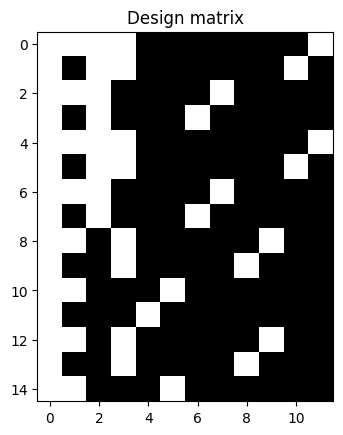

In [77]:
X_3 = %R model.matrix(~ awesome + popular + overrated + awesome:popular:overrated)
show_x(X_3)

So what went wrong?  For the same reasons as before, the single terms `awesome`, `popular`, `overrated` each got contrast coding, and therefore one column each.  So far so good.  Next we look at `awesome:popular:overrated`.   We first remove `awesome` and ask "have we seen `popular:overrated`?"  No, hence we will use indicator coding for `awesome` in the interaction.  For the same reason we get indicator coding for all of the factors in the interaction, and therefore a full 8 columns for the indicator coding of the interaction.  These 8 columns also code the column space of the intercept and the single terms `awesome`, `popular`, `overrated` that we have already included in the design.

There are more odd cases in `R` design matrix coding described in http://patsy.readthedocs.org/en/latest/R-comparison.html

## A Python note

Nathaniel Smith has written an `R`-like formula framework in Python. See https://github.com/pydata/patsy and http://patsy.readthedocs.org/en/latest/

## That's it?

Is this kind of description the best way of describing a design in terms of terms and factors?  It has a lot of magic in it.  The post-processing, column rearrangement and pruning look ugly to my Python-tuned eyes.  Predicting the design matrix from the formula can be difficult for designs that are not simple.  You will need to keep in mind all the rules above, and that can be confusing.  I wonder if this kind of shorthand is a barrier to understanding of linear models in terms of matrices and column spaces.  Can we do better?  I suppose we'll have to try stuff out to see...

## Thanks

* Jean-Baptiste Poline for several edits and suggestions
* Nathaniel Smith for typically thought-provoking discussion and great documentation
* Jonathan Taylor for his patient feedback